# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [1]:
DATA_DIR = '../data'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

In [2]:
import os

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR]:
    if not os.path.exists(pth):
        os.makedirs(pth)


# Data Prep

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm

from sklearn.metrics.pairwise import rbf_kernel

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FunctionTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from datetime import date

from catboost import CatBoostClassifier

import optuna
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import mlflow
import mlflow.sklearn
import warnings
warnings.simplefilter('ignore')

## Read the Data

In [4]:
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv', low_memory=False)
invoice_train = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', low_memory=False)

client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv', low_memory=False)
invoice_test = pd.read_csv(f'{TEST_DIR}/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv', low_memory=False)

In [5]:
import logging

# Setup basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')



## Data Understanding

In [6]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [7]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [8]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [9]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [10]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [11]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [12]:
invoice_train['counter_coefficient'].value_counts()

counter_coefficient
1     4475102
2         886
3         321
40        197
30        137
0          46
6          30
4          12
10          6
20          3
9           3
50          2
33          1
5           1
11          1
8           1
Name: count, dtype: int64

In [13]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [14]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [15]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [16]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [17]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

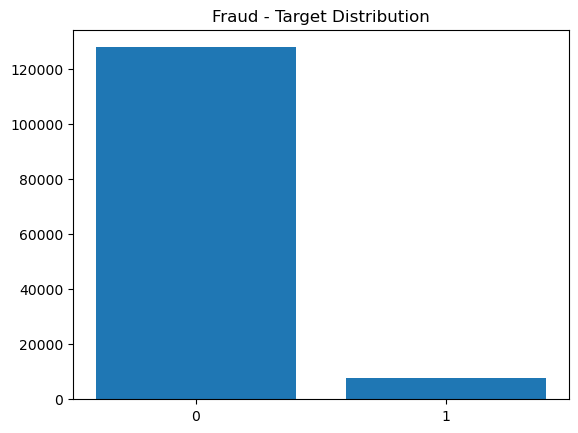

In [18]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

In [19]:
fraudactivities

target
0.0    127927
1.0      7566
Name: client_id, dtype: int64

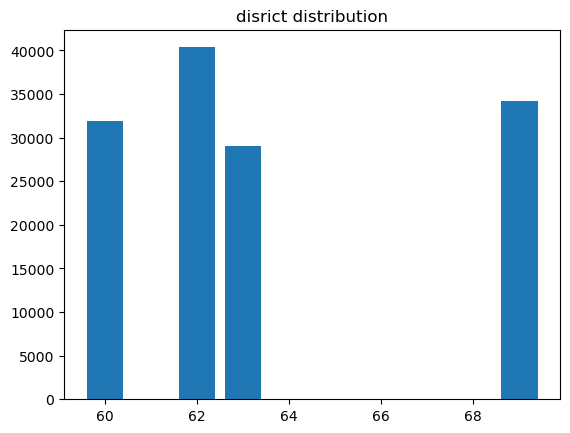

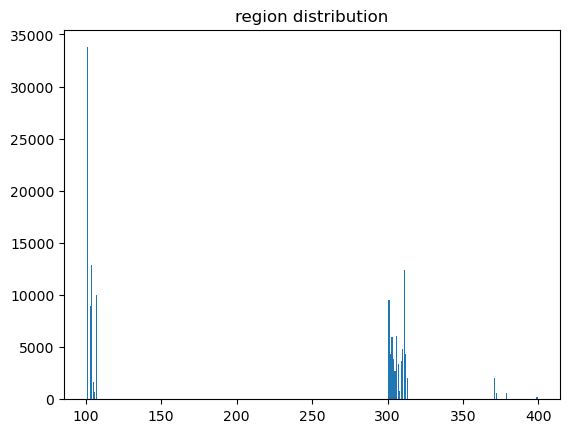

In [20]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title(col+' distribution')
    plt.show()

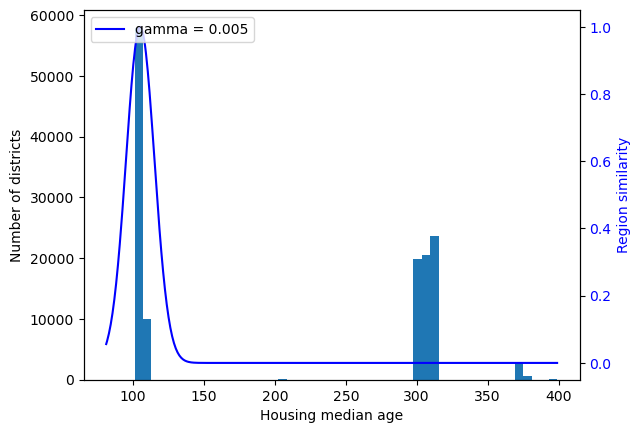

In [21]:
# generate graph for rbf kernel

ages = np.linspace(client_train[["region"]].min()-20,
                   client_train[["region"]].max(),
                   500).reshape(-1, 1)
gamma1 = 0.005

rbf1 = rbf_kernel(ages, [[105]], gamma=gamma1)


fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(client_train[["region"]], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.005")

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Region similarity", color=color)

plt.legend(loc="upper left")

plt.show()

## Feature Engineering

In [22]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [23]:
target = client_train['target']
client_train = client_train.drop(columns=['target'])

In [24]:
# This function aggregates the invoice data by client ID and merges it with the client data.
# It calculates various statistics for different columns in the invoice data.
# The input parameters are:
# - client_data: The client data dataframe.
# - invoice_data: The invoice data dataframe.
# The function returns the merged dataframe.

# feature on Invoice does not come in consistent pattern (3 invoices have back to back)
# fruad people mess up counter/index --> eng features how much energy consumed since last time 

# consumption level (infrench) add all 4 levels 


#index is the number on the counter 

#if you substract these two and substract features (something is going on) --> take a difference btw them

# old index new index and total consumption level


# how many days elapse since last invoice; how much energy data they use on average 
# how many unique counter they have (17)

# some values are way too large (some column just moved, copy paste); move these back 


# some test ID exist both in training and test set; --> email stephen 

def aggregate_by_client_id(client_data, invoice_data):
        #feature total consumption levels vs index difference
        invoice_data['consumption_diff'] = invoice_data[['consommation_level_1', 'consommation_level_2','consommation_level_3','consommation_level_4']].sum(axis=1) 
        -( invoice_data['new_index'] - invoice_data['old_index'])
        
        aggs = {}
        aggs['invoice_date'] = ['min','max','count']
        aggs['consumption_diff'] = ['sum','mean']
        aggs['tarif_type'] = ['count']
        aggs['reading_remarque'] = ['mean']
        aggs['counter_statue'] = ['count']
        aggs['counter_coefficient'] = ['mean']
        aggs['consommation_level_1'] = ['mean','sum']
        aggs['consommation_level_2'] = ['mean','sum']
        aggs['consommation_level_3'] = ['mean','sum']
        aggs['consommation_level_4'] = ['mean','sum']
        # how many unique counters do they have
        aggs['counter_number'] = ['nunique']
        aggs['months_number'] = ['mean']
        
        # Group the invoice data by client ID and calculate the aggregated statistics
        invoice_agg = invoice_data.groupby(['client_id']).agg(aggs)
        
        # Rename the columns of the aggregated dataframe
        invoice_agg.columns = ['_'.join(col).strip() for col in invoice_agg.columns.values]
        
        # Reset the index of the aggregated dataframe
        invoice_agg.reset_index(inplace=True)
        
        #add two features Frequency of the invoice;the energy consumption on average per day
        invoice_agg[['invoice_date_max','invoice_date_min']] = invoice_agg[['invoice_date_max','invoice_date_min']].apply(pd.to_datetime)
        invoice_agg['tenure_days']= (invoice_agg['invoice_date_max'] - invoice_agg['invoice_date_min']).dt.days

        invoice_agg['invoice_freq'] = invoice_agg['tenure_days']/invoice_agg['invoice_date_count']
        invoice_agg['consumption_sum'] = invoice_agg[['consommation_level_1_sum', 'consommation_level_2_sum','consommation_level_3_sum']].sum(axis=1)

        #if tenure days is 0, keep it as it is, else divide by tenure days
        invoice_agg['daily_consumption'] = invoice_agg.apply(lambda x: x['consumption_sum'] if x['tenure_days'] == 0 else x['consumption_sum']/x['tenure_days'], axis=1)

        columns_to_drop = ['invoice_date_min', 'invoice_date_max', 'invoice_date_count', 'consommation_level_1_sum', 'consommation_level_2_sum', 'consommation_level_3_sum', 
        'consommation_level_4_sum', 'consumption_sum']
        invoice_agg.drop(columns_to_drop, axis=1, inplace=True)

        client_data['creation_date'] = pd.to_datetime(client_data['creation_date'])
        client_data['creation_day_diff'] = (client_data['creation_date'] - pd.Timestamp(date.today())).dt.days.astype(int)


        # Merge the aggregated invoice data with the client data
        invoice_final = pd.merge(client_data, invoice_agg, on='client_id', how='left')

        #drop two remaining cat features client_id column and creation_date
        invoice_final.drop(['client_id', 'creation_date'], axis=1, inplace=True)
        
        # Return the merged dataframe
        return invoice_final


In [25]:
agg_train = aggregate_by_client_id(client_train , invoice_train)
agg_test = aggregate_by_client_id(client_test , invoice_test) 

In [28]:
# create multiple features based on region values
def rbf_transformer(Y):
    return make_pipeline(
        FunctionTransformer(rbf_kernel, kw_args=dict(Y=Y, gamma=0.1),feature_names_out="one-to-one"),
        StandardScaler()
    )
# def num_transformer():
#     return make_pipeline(
#             FunctionTransformer(lambda x: x.astype(int), validate=False)
#         )




preprocessing = ColumnTransformer([
 ('onehot', OneHotEncoder(handle_unknown="ignore"), ['disrict']),
 ("rbf_transformer_105", rbf_transformer([[105]]), ["region"]),
 ("rbf_transformer_305", rbf_transformer([[305]]), ["region"]),
 ("rbf_transformer_375", rbf_transformer([[375]]), ["region"]),
 ], remainder="passthrough")

# client_train_preped = preprocessing.fit_transform(agg_train)

# preprocessing.get_feature_names_out()

# Modelling

In [36]:
logging.info("Training Models...")

2023-12-06 23:04:26,621 - INFO - Training Models...


In [29]:
#potential to change the k neighbours; sampling strategy 

light_GBM =ImPipeline([
    ('preprocessing', preprocessing),
    # ('smote', SMOTE(sampling_strategy = 0.3,random_state=42)),
    
    ('model', LGBMClassifier(boosting_type='gbdt',class_weight='balanced',))
])
light_GBM.fit(agg_train, target)

[LightGBM] [Info] Number of positive: 7566, number of negative: 127927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3606
[LightGBM] [Info] Number of data points in the train set: 135493, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['disrict']),
                                                 ('rbf_transformer_105',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function rbf_kernel at 0x0000012722FB7B00>,
                                                                                       kw_args={'Y': [[105]],
                                                                                                'gamma': 0.1})),
                                                                  ('st...
                                                                                                'gamma': 0.1})),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['region']),
                                                 ('rbf_transformer_375',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function rbf_kernel at 0x0000012722FB7B00>,
                                                                                       kw_args={'Y': [[375]],
                                                                                                'gamma': 0.1})),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['region'])])),
                ('model', LGBMClassifier(class_weight='balanced'))])

In [51]:


fraud_predictions = light_GBM.predict_proba(agg_test)


fraud_predictions = fraud_predictions[:, 1]

## rf tuning

In [32]:


def objective(trial,X,y):
    # Define the hyperparameters to be optimized
    max_samples = trial.suggest_float("max_samples", 0.5, 0.7)  # Fraction of samples to be used for each tree
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100)

    # Create the pipeline with the suggested parameters
    clf_rf = ImPipeline([
        ('preprocessing', preprocessing),
        # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
        ('model', RandomForestClassifier(n_estimators=1000,
                                             max_samples=max_samples, 
                                             min_samples_split=min_samples_split, 
                                             class_weight= 'balanced',
                                             n_jobs=3,
                                             random_state=42))
    ])
    
    # # Fit the model
    # clf_rf.fit(agg_train, target)
    cv_scores = cross_val_score(clf_rf, X, y, cv=5, n_jobs=3, scoring="roc_auc")
    score = np.mean(cv_scores)
    # scorestd = cv_scores.std()
    return score  # Replace with appropriate metric

# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(lambda trial: objective(trial, agg_train, target), n_trials=15,  gc_after_trial=True)

# Print the optimal parameters
print(study.best_params)


[I 2023-12-09 23:19:03,817] A new study created in memory with name: no-name-4552aad9-599d-4c33-8168-75e141d44e9e
[I 2023-12-09 23:25:22,108] Trial 0 finished with value: 0.8327351036390033 and parameters: {'max_samples': 0.625596999412947, 'min_samples_split': 25}. Best is trial 0 with value: 0.8327351036390033.
[I 2023-12-09 23:31:07,082] Trial 1 finished with value: 0.8314430774107443 and parameters: {'max_samples': 0.5797588273690013, 'min_samples_split': 13}. Best is trial 0 with value: 0.8327351036390033.
[I 2023-12-09 23:36:48,575] Trial 2 finished with value: 0.8332348803753422 and parameters: {'max_samples': 0.6265756203213676, 'min_samples_split': 38}. Best is trial 2 with value: 0.8332348803753422.
[I 2023-12-09 23:42:18,416] Trial 3 finished with value: 0.8287221930463419 and parameters: {'max_samples': 0.5264055689883278, 'min_samples_split': 2}. Best is trial 2 with value: 0.8332348803753422.
[I 2023-12-09 23:47:25,456] Trial 4 finished with value: 0.8333181140169144 and 

{'max_samples': 0.6923515142718805, 'min_samples_split': 73}


In [33]:
study.best_params

{'max_samples': 0.6923515142718805, 'min_samples_split': 73}

In [30]:
clf_rf = ImPipeline([
        ('preprocessing', preprocessing),
        # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
        ('model', RandomForestClassifier(n_estimators=1000,
                                            #  **study.best_params,
                                            max_samples= 0.605199046299782, min_samples_split= 60,
                                            class_weight='balanced',
                                             n_jobs=-1,
                                             random_state=42))
    ])

cv_scores = cross_val_score(clf_rf, agg_train, target, cv=5, n_jobs=-1, scoring="roc_auc")
# clf_rf.fit(agg_train, target)
# fraud_predictions = clf_rf.predict_proba(agg_test)


# fraud_predictions = fraud_predictions[:, 1]


In [31]:
# cv_scores.mean()

0.833139342536348

## Tune catboost

In [29]:
def objective(trial,X,y):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),  # CatBoost uses 'depth' instead of 'num_leaves'
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'max_bin': trial.suggest_int('max_bin', 100, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 5),  # Similar to 'lambda_l1' and 'lambda_l2'
        # Fixed parameters
        'iterations': 1000,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'auto_class_weights': 'Balanced',
        'thread_count':4,
        # Add other parameters as needed
    }
    cat_boost = ImPipeline([
            ('preprocessing', preprocessing),
            # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
            ('model', CatBoostClassifier(**param))
        ])

    cv_scores = cross_val_score(cat_boost, X, y, cv=5, n_jobs=-1, scoring="roc_auc")
    score = np.mean(cv_scores)
    return score

# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')

# Start the optimization
study.optimize(lambda trial: objective(trial, agg_train, target), n_trials=100,  gc_after_trial=True)

# Print the optimal parameters
print(study.best_params)

[I 2023-12-10 01:18:35,605] A new study created in memory with name: no-name-ce741be0-c871-4841-8f78-6b4f4026ad70
[I 2023-12-10 01:20:31,719] Trial 0 finished with value: 0.8316068805029962 and parameters: {'learning_rate': 0.04996675682411394, 'depth': 6, 'min_data_in_leaf': 41, 'max_bin': 206, 'l2_leaf_reg': 0.7609530273425635}. Best is trial 0 with value: 0.8316068805029962.
[I 2023-12-10 01:23:12,527] Trial 1 finished with value: 0.8366238281893015 and parameters: {'learning_rate': 0.01850856810273159, 'depth': 8, 'min_data_in_leaf': 50, 'max_bin': 138, 'l2_leaf_reg': 3.2310132719792266}. Best is trial 1 with value: 0.8366238281893015.
[I 2023-12-10 01:31:32,998] Trial 2 finished with value: 0.8104213827115234 and parameters: {'learning_rate': 0.04751776416001719, 'depth': 10, 'min_data_in_leaf': 13, 'max_bin': 228, 'l2_leaf_reg': 2.1005355138118675}. Best is trial 1 with value: 0.8366238281893015.
[I 2023-12-10 01:38:54,445] Trial 3 finished with value: 0.7986777873976388 and para

{'learning_rate': 0.03308847301923811, 'depth': 5, 'min_data_in_leaf': 1, 'max_bin': 250, 'l2_leaf_reg': 4.0572360381723875}


In [ ]:
study.best_params
#best cv score is 0.8363991169354101

{'learning_rate': 0.01977973649239961,
 'depth': 5,
 'min_data_in_leaf': 36,
 'max_bin': 125,
 'l2_leaf_reg': 1.1430941888323707}

In [35]:
# Example parameter values
param = {
    'learning_rate': 0.1,  # Example fixed value
    'max_depth': 6,            # Example fixed value
    'min_data_in_leaf': 20,  # Example fixed value
    'max_bin': 100,
    'l2_leaf_reg': 3.0,    # Example fixed value
    # You can add other CatBoost specific parameters here
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'auto_class_weights': 'Balanced',
    'iterations': 1000,
    'thread_count':4,
}


# Example of using these parameters in CatBoostClassifier




cat_boost = ImPipeline([
        ('preprocessing', preprocessing),
        # ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Adjust as needed
        ('model', CatBoostClassifier(**param))
    ])

cv_scores = cross_val_score(cat_boost, agg_train, target, cv=5, n_jobs=-1, scoring="roc_auc")

In [36]:
cv_scores

array([0.82117265, 0.82673558, 0.83228168, 0.81556242, 0.82318387])

In [35]:
gradient_GBM =ImPipeline([
    ('preprocessing', preprocessing),
    ('smote', SMOTE(sampling_strategy = 0.3,random_state=42)),
    ('model', GradientBoostingClassifier())
])
gradient_GBM.fit(agg_train, target)
fraud_predictions = gradient_GBM.predict(agg_test)

In [38]:
xgboost_pipeline = ImPipeline([
    ('preprocessing', preprocessing),
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),
    ('model', xgb.XGBClassifier())
])

xgboost_pipeline.fit(agg_train, target)
fraud_predictions = xgboost_pipeline.predict(agg_test)


In [52]:
preds = pd.DataFrame(fraud_predictions, columns=['target'])
preds.head()
sub_client_id = client_test['client_id']
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.292410
1,test_Client_1,0.779289
2,test_Client_10,0.308421
3,test_Client_100,0.117898
4,test_Client_1000,0.682901


In [53]:
submission.to_csv(f'{OUTPUT_DIR}/submission_lightbgm_new_features.csv', index=False)

## Train LGBM *Classifier* 

### the following code is to log MLflow

In [30]:
# X = train.drop(columns=['target'])
# y = train['target']

### Train Test split

In [31]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
# Create a pipeline
LGBM_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(boosting_type='gbdt'))
])
mlflow_run_tracking('LGBMClassifier',LGBM_pipeline, X_train, y_train, X_test, y_test )

[LightGBM] [Info] Number of positive: 6002, number of negative: 102392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 108394, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055372 -> initscore=-2.836716
[LightGBM] [Info] Start training from score -2.836716


In [21]:
# Create a pipeline
decision_tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier())
])


In [38]:
# Create a pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
])
mlflow_run_tracking('SVM',svm_pipeline, X_train, y_train, X_test, y_test )

In [33]:
def mlflow_run_tracking(model_name, model, X_train, y_train, X_test, y_test):
    """
    Function to track model training using MLflow.

    Parameters:
    - model_name (str): Name of the model.
    - model: The machine learning model object.
    - X_train: Training data features.
    - y_train: Training data labels.
    - X_test: Testing data features.
    - y_test: Testing data labels.

    Example:
    mlflow_run_tracking("LGBMClassifier", LGBM_pipeline, X_train, y_train, X_test, y_test)
    """
    mlflow.set_tracking_uri('http://localhost:5000') 
    with mlflow.start_run():
        mlflow.set_tag("model", model_name)

        model.fit(X_train, y_train)

        predictions = model.predict(X_test)
        AUC = metrics.roc_auc_score(y_test, predictions)

        mlflow.sklearn.log_model(LGBM_pipeline, model_name)


In [23]:
mlflow.set_tracking_uri('http://localhost:5000') 
with mlflow.start_run():
    # Random Forest Regressor
    mlflow.set_tag("model", "LGBMClassifier")
    # grid_search_rf = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_squared_error')
    # grid_search_rf.fit(X_train, y_train)
    
    LGBM_pipeline.fit(X_train, y_train)
    
    # best_rf = grid_search_rf.best_estimator_
    # mlflow.log_params(grid_search_rf.best_params_)

    # Fit the StandardScaler
    # decision_tree_pipeline['scaler'].fit(X_train)
    predictions = LGBM_pipeline.predict(X_test)
    AUC = metrics.roc_auc_score(y_test, predictions)

    mlflow.sklearn.log_model(LGBM_pipeline, "LGBMClassifier")


[LightGBM] [Info] Number of positive: 6002, number of negative: 102392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1255
[LightGBM] [Info] Number of data points in the train set: 108394, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055372 -> initscore=-2.836716
[LightGBM] [Info] Start training from score -2.836716


In [22]:
mlflow.set_tracking_uri('http://localhost:5000')  # Replace with your MLflow tracking server URI

with mlflow.start_run():
    # Random Forest Regressor
    mlflow.set_tag("model", "DecisionTreeClassifier")
    # grid_search_rf = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='neg_mean_squared_error')
    decision_tree_pipeline.fit(X_train, y_train)
    
    # best_rf = grid_search_rf.best_estimator_
    # mlflow.log_params(grid_search_rf.best_params_)

    # Fit the StandardScaler
    # decision_tree_pipeline['scaler'].fit(X_train)
    predictions = decision_tree_pipeline.predict(X_test)
    AUC = metrics.roc_auc_score(y_test, predictions)
    mlflow.log_metric("AUC", AUC)

    mlflow.sklearn.log_model(decision_tree_pipeline, "DecisionTreeClassifier")


In [ ]:
model = LGBMClassifier(boosting_type='gbdt', num_iterationss=500)
model.fit(x_train, y_train)

[LightGBM] [Warning] Unknown parameter: num_iterationss


LGBMClassifier(num_iterationss=500)

In [ ]:
x_train.disrict.unique()

array([60, 69, 62, 63])

## Make Predictions on test set

In [ ]:
test.columns

Index(['disrict', 'client_catg', 'region', '1transactions_count',
       'consommation_level_1_mean', 'consommation_level_2_mean',
       'consommation_level_3_mean', 'consommation_level_4_mean'],
      dtype='object')

In [ ]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,0.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [ ]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation
